In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Make sure that you have the dependency installed on your system
# If not installed, install by running the following
!pip install kafka-python

## import required libraries

In [ ]:
import pandas as pd
import ast
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
from google.colab import files
import io
from imblearn.over_sampling import SMOTE
import time
from sklearn.preprocessing import StandardScaler
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np
import pickle

### upload static data file

In [ ]:
def get_static_data(file_name):
  data = files.upload()
  return data

In [ ]:
data = get_static_data('iot_static_data.csv')

Saving iot_static_data.csv to iot_static_data.csv


In [ ]:
def read_data(data):
  df = pd.read_csv(io.BytesIO(data['iot_static_data.csv']))
  return df

In [ ]:
def read_streaming():
  df = pd.DataFrame()#Dataframe to hold row of streaming data
  data_list = []#list to hold data frame of sreamingdata

  # instantiate the KafkaConsumer Class using the arguments mentioned.
  consumer = KafkaConsumer(
      # write your arguments values
      'task_name', 
      bootstrap_servers="",
      sasl_plain_username="",
      sasl_plain_password="",
      security_protocol="",
      sasl_mechanism="",
      auto_offset_reset='',
      enable_auto_commit=
  )

  # Data Stream flowing in.
  i = 0
  for message in consumer:
    try:
      # print(f"Consuming the {i+1}th data packet!")
        
      data_packet = message.value
      # print(data_packet)
          
      ##############################################
      dict_str = data_packet.decode("UTF-8")
      dict_ = ast.literal_eval(dict_str)

      dff = pd.DataFrame.from_records([dict_])
      data_list.append(dff)
    
    except:
      continue

      ##############################################
      
    if i == 4999:#read 5000 record in each iteration
      break

    i += 1

  return data_list

In [ ]:
# set all streaming data in one data frame
def get_stream_as_df(df, data_list):
  for i in range(len(data_list)):
    df = df.append(data_list[i], ignore_index=True)
  return df

In [ ]:
#split streaming data frame into features and labels
def get_feature_label(df):
  # set the features of the traffic into X
  X = df.drop(labels = ["Class"], axis=1) 

  # set the labels of the traffic into y
  y = df["Class"].values
  
  return X, y

In [ ]:
def do_preprocessing(X, y):
  # scale the features of the traffic using standard scaler
  X = pd.get_dummies(X)
  scaler = StandardScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X)

  # apply features selection for the coming traffic based on the number of features that is the static model trained on which equal to 66 feature
  n_fea = SelectKBest(score_func=f_classif, k=95)
  fit = n_fea.fit(X_scaled, y)
  set_printoptions(precision=3)
  features = fit.transform(X_scaled)
  # print(features)
  return features, y

In [ ]:
#method to call model which was trained in static part
def get_model():
  filename = 'finalized_model_multiclassification.sav'
  model = pickle.load(open(filename, 'rb'))
  return model

In [ ]:
#get the model predicition and score on streaming data
def test_stream(model, x, y):
  pred = model.predict(x)
  result = model.score(x, y)
  return pred, result

In [ ]:
def plot_conf_mat(model, x, y):
  plot_confusion_matrix(model, x, y, display_labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])  
  plt.show()

In [ ]:
#method to get macro average precision, recalland f1_score to measure model performance
def get_performance_rport(y, pred):
  # clf_report = classification_report(y, pred, output_dict=True)
  precision,recall,fscore,support=score(y, pred, average='macro')
  return precision, recall, fscore

In [ ]:
#mthod to combine model performances in each iteration 
def save_model_performance(test_performance, test_acc, precision, recall, fscore, acc):
  test_performance = test_performance.append({'precision' : precision, 'recall' : recall, 'fscore' : fscore}, 
                ignore_index = True)
  
  test_acc = test_acc.append({'accuracy' : acc}, 
                ignore_index = True)
  return test_performance, test_acc

In [ ]:
#remove 5000 record (length of streaming data) from the head of static data frame
def remove_part_static(df_static, new_len):
  # df_static.drop(df_static.head(new_len).index, inplace=True)
  df_static = df_static.iloc[new_len:]
  return df_static

In [ ]:
#add 5000 record (length of streaming data) to the tail of static data frame
def add_part_streaam(df_static, df_stream):
  df_static = df_static.append(df_stream, ignore_index = True)
  return df_static

In [ ]:
## In the begining, I used thi method to make train data balance. 
# But, later I decide to work with thedata as it is "imbalanced"

# def sampling_data(X_train, y_train):
#   sm = SMOTE()
#   X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
#   return X_resampled, y_resampled

In [ ]:
#method to retrain the adaptive model
def retrain_model(model, X_resampled, y_resampled):
  model.fit(X_resampled, y_resampled)
  return model

In [ ]:
#method which combine the whole process
def run_process():
  start = time.time()

  test_performance_stream = pd.DataFrame(columns = ['precision', 'recall', 'fscore'])
  test_acc_stream = pd.DataFrame(columns=['accuracy'])

  test_performance_static = pd.DataFrame(columns = ['precision', 'recall', 'fscore'])
  test_acc_static = pd.DataFrame(columns=['accuracy'])

  df_static = read_data(data)
  static_model = get_model()
  adaptive_model = get_model()

  for i in range(20):
    data_list = []
    data_list = read_streaming()

    df = pd.DataFrame()
    df = get_stream_as_df(df, data_list)
    df.columns = df_static.columns

    X, y = get_feature_label(df)
    
    features, y = do_preprocessing(X, y)
  
    # test performance of static model on stream data
    pred_1, score_1 = test_stream(static_model, features, y)
    print("Score of static model on testing streaming data iS: ", score_1)
    plot_conf_mat(static_model, features, y)
    precision, recall, fscore = get_performance_rport(y, pred_1)
    test_performance_static, test_acc_static = save_model_performance(test_performance_static, test_acc_static, precision, recall, fscore, score_1)

    #Test performance of adaptive model on stream data  
    pred, score = test_stream(adaptive_model, features, y)
    print("Score of adaptive model on testing streaming data iS: ", score)
    plot_conf_mat(adaptive_model, features, y)
    precision, recall, fscore = get_performance_rport(y, pred)
    test_performance_stream, test_acc_stream = save_model_performance(test_performance_stream, test_acc_stream, precision, recall, fscore, score)
    
    # plot the numbers of BENIGN and ATTACK traffic
    g = sns.countplot(y)
    g.set_xticklabels(['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])
    plt.show()

    #remove 5000 record from the head of static dataset
    # print(len(df_static), "before remove")
    df_static = remove_part_static(df_static, len(df))
    # print(len(df_static), "after remove")

    #add 500 stream records to the tail of static dataset
    df_static = add_part_streaam(df_static, df)
    # print(len(df_static), "after add")

    XX, yy = get_feature_label(df_static)
    
    features_new, y_new = do_preprocessing(XX, yy)
    # print(len(features_new), len(y_new))

    # features_new, y_new = sampling_data(features_new, y_new)

    adaptive_model = retrain_model(adaptive_model, features_new, y_new)

  end = time.time()
  print("Time needed to run the whole process is: ", (end - start))
  return test_performance_static, test_acc_static, test_performance_stream, test_acc_stream

Score of static model on testing streaming data iS:  0.9034


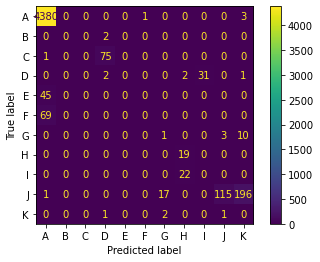

Score of adaptive model on testing streaming data iS:  0.9034


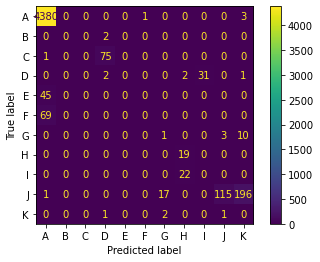

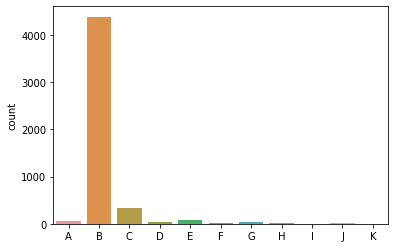

Score of static model on testing streaming data iS:  0.9032


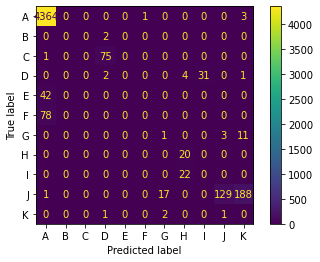

Score of adaptive model on testing streaming data iS:  0.9234


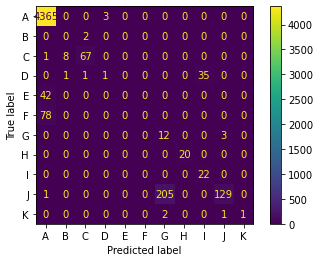

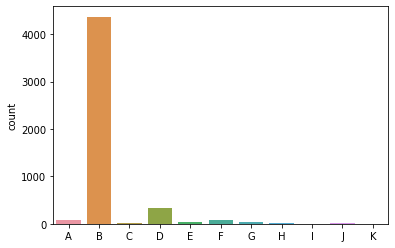

Score of static model on testing streaming data iS:  0.9036


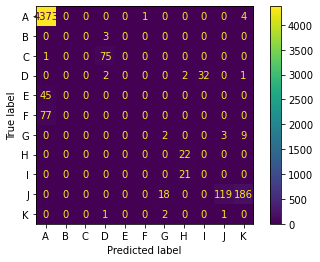

Score of adaptive model on testing streaming data iS:  0.9082


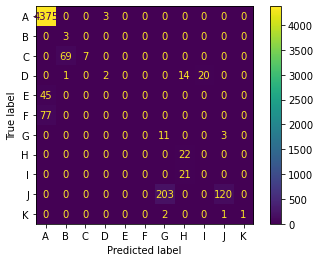

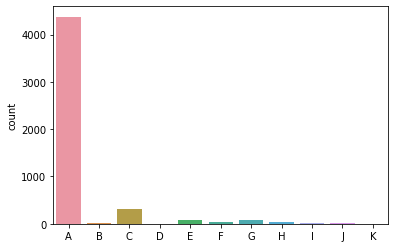

Score of static model on testing streaming data iS:  0.9052


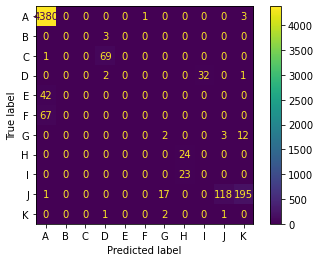

Score of adaptive model on testing streaming data iS:  0.9034


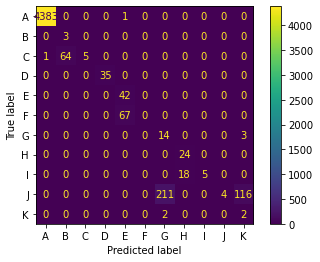

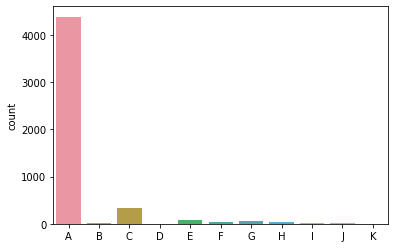

Score of static model on testing streaming data iS:  0.9032


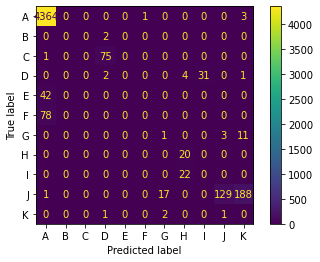

Score of adaptive model on testing streaming data iS:  0.9296


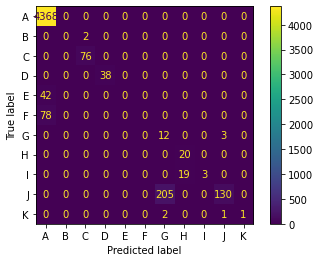

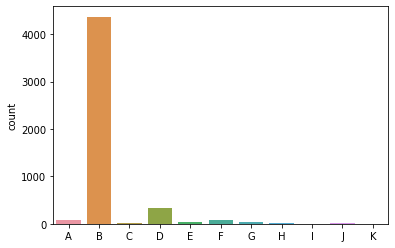

Score of static model on testing streaming data iS:  0.9036


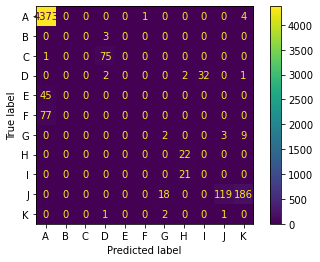

Score of adaptive model on testing streaming data iS:  0.9554


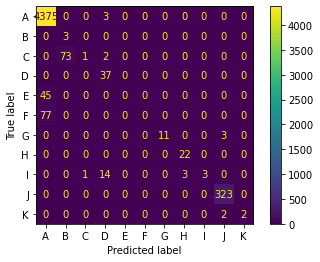

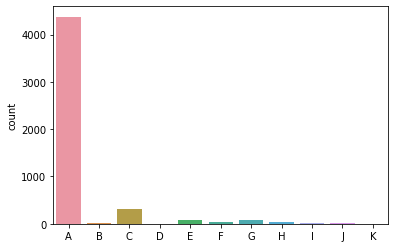

Score of static model on testing streaming data iS:  0.9026


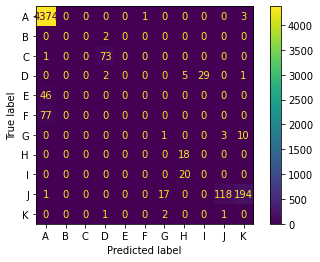

Score of adaptive model on testing streaming data iS:  0.9534


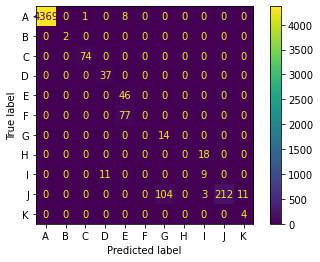

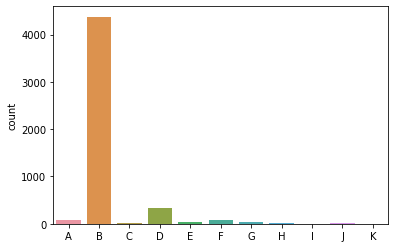

Score of static model on testing streaming data iS:  0.9006


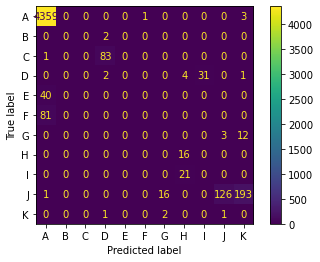

Score of adaptive model on testing streaming data iS:  0.9642


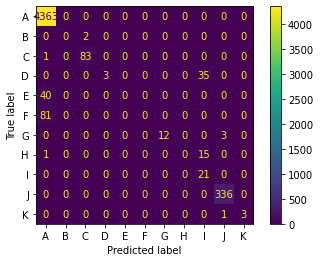

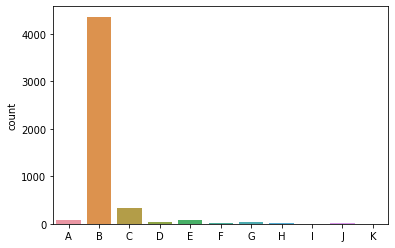

Score of static model on testing streaming data iS:  0.9


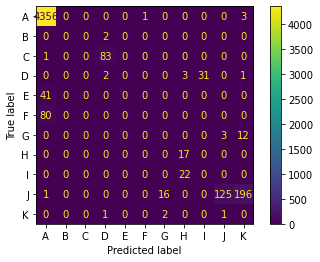

Score of adaptive model on testing streaming data iS:  0.9072


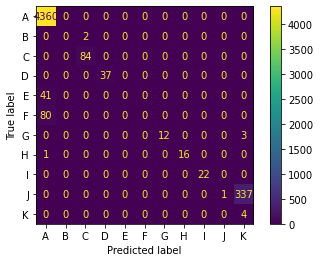

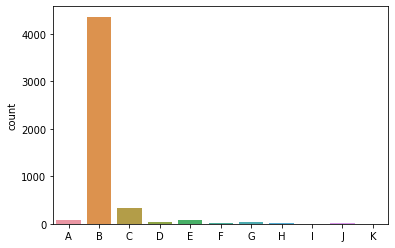

Score of static model on testing streaming data iS:  0.9036


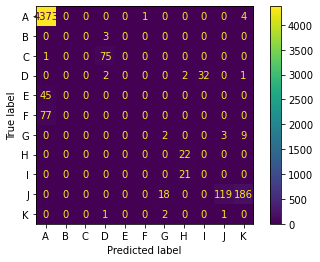

Score of adaptive model on testing streaming data iS:  0.95


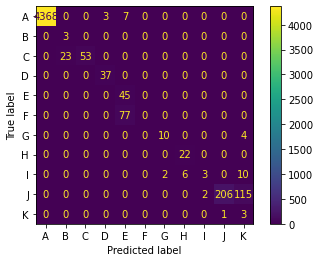

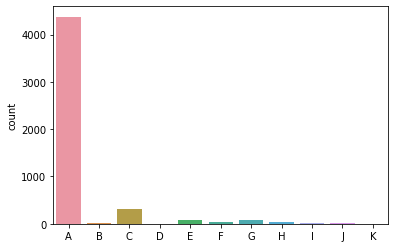

Score of static model on testing streaming data iS:  0.9034


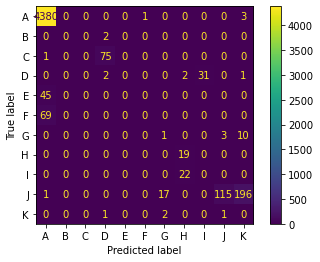

Score of adaptive model on testing streaming data iS:  0.9512


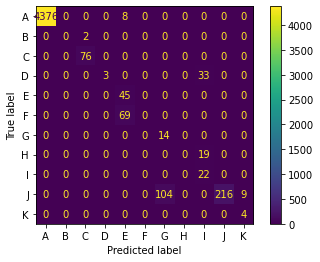

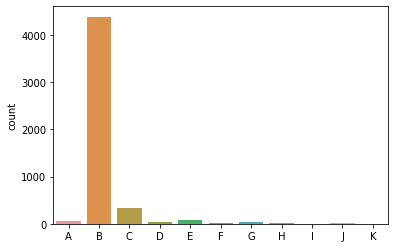

Score of static model on testing streaming data iS:  0.9116


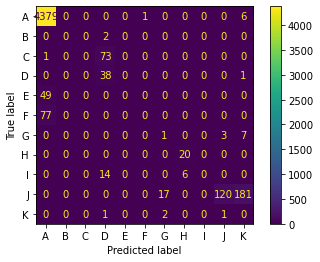

Score of adaptive model on testing streaming data iS:  0.8992


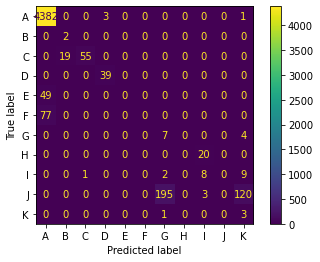

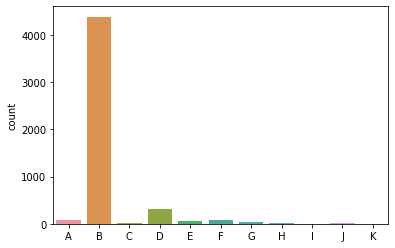

Score of static model on testing streaming data iS:  0.9


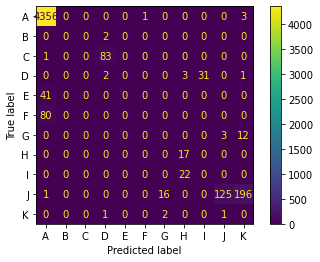

Score of adaptive model on testing streaming data iS:  0.8994


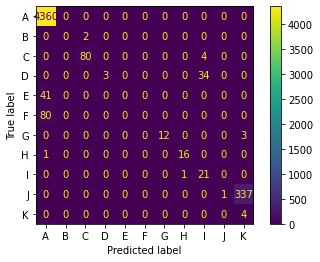

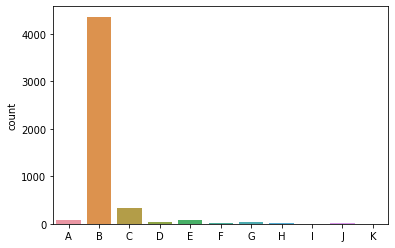

Score of static model on testing streaming data iS:  0.9034


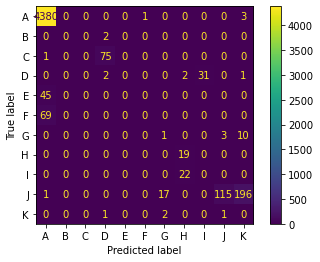

Score of adaptive model on testing streaming data iS:  0.9476


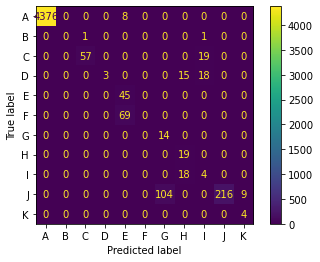

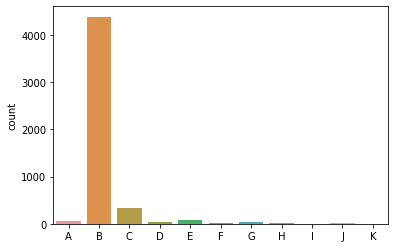

Score of static model on testing streaming data iS:  0.9116


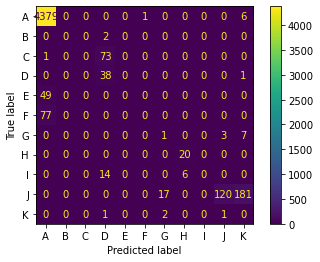

Score of adaptive model on testing streaming data iS:  0.949


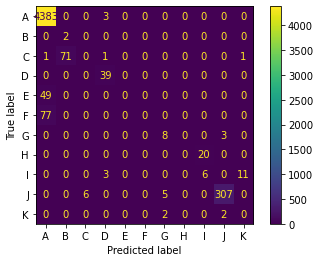

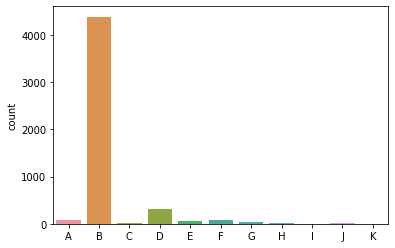

Score of static model on testing streaming data iS:  0.9


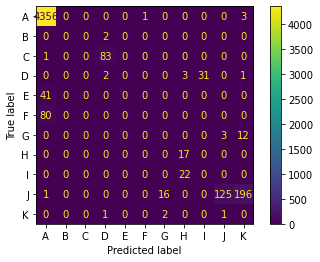

Score of adaptive model on testing streaming data iS:  0.8948


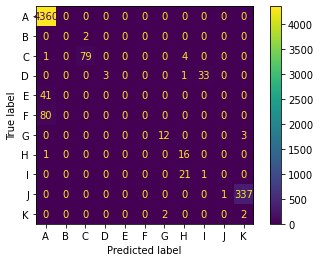

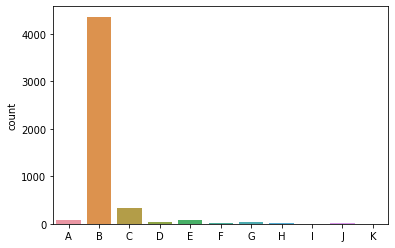

Score of static model on testing streaming data iS:  0.9


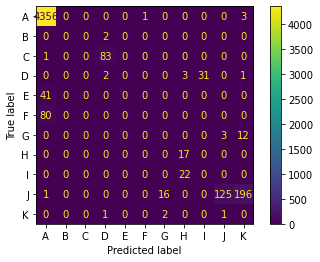

Score of adaptive model on testing streaming data iS:  0.9726


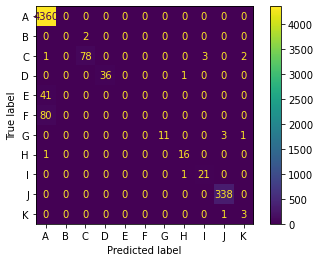

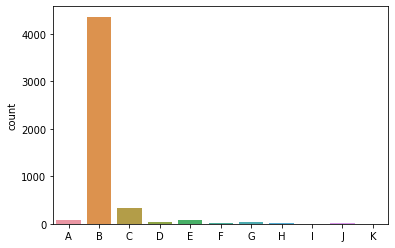

Score of static model on testing streaming data iS:  0.9116


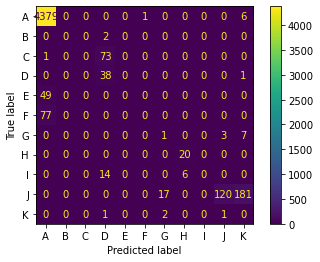

Score of adaptive model on testing streaming data iS:  0.9634


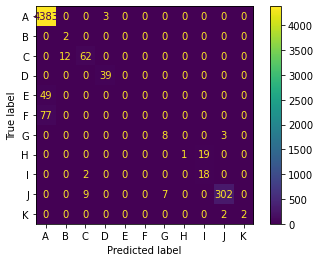

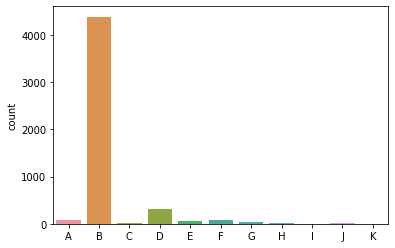

Score of static model on testing streaming data iS:  0.9034


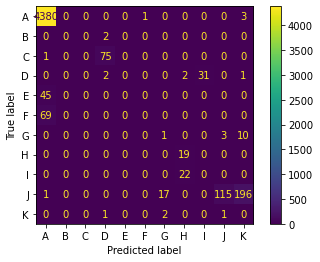

Score of adaptive model on testing streaming data iS:  0.9508


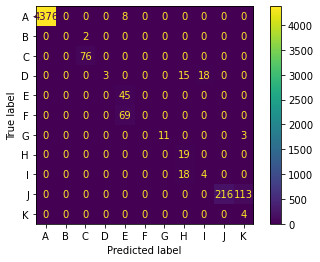

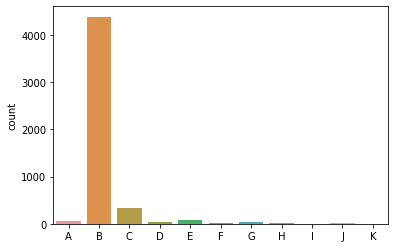

Score of static model on testing streaming data iS:  0.9036


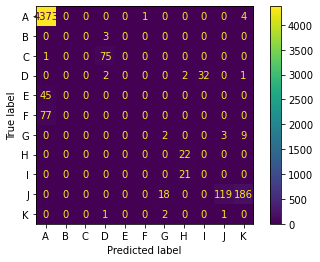

Score of adaptive model on testing streaming data iS:  0.9636


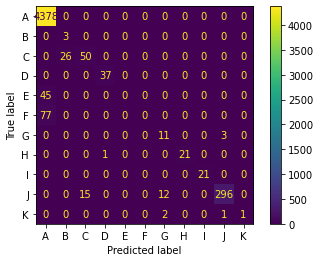

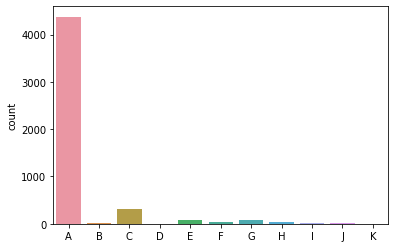

Time needed to run the whole process is:  909.7149448394775


In [ ]:
performance_static, performance_acc_static, performance_stream, performance_acc_stream = run_process()

### preparation to plot line graph foraccuracies, precisions, recalls and f1_scores

In [ ]:
#array of number of iterations, to plot line graphs for precision, recalland f1_score
run_times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
#get accuracy, precision, recall anf f1_score of static model in a separate lists
acc_static_list = performance_acc_static['accuracy'].tolist()
prec_static_list = performance_static['precision'].tolist()
recall_static_list = performance_static['recall'].tolist()
fscore_static_list = performance_static['fscore'].tolist()

In [ ]:
#get accuracy, precision, recall anf f1_score of adaptive model in a separate lists
acc_stream_list = performance_acc_stream['accuracy'].tolist()
prec_stream_list = performance_stream['precision'].tolist()
recall_stream_list = performance_stream['recall'].tolist()
fscore_stream_list = performance_stream['fscore'].tolist()

In [ ]:
# method to plot line graph for any given accuracy, precision, recall or f1_score
def plot_performance_graph(X, y1, y2, metric_sta, metric_str, X_title, y_title, metric):
  width = 10
  height = 8
  graph_shape = (width, height)
  plt.figure(figsize=graph_shape)
  plt.xticks(np.arange(len(X)+1), np.arange(0, len(X)+1))

  plt.plot(X, y1, label = metric_sta)
  plt.plot(X, y2, label = metric_str)
  plt.xlabel(X_title)
  plt.ylabel(y_title)

  plt.title('Model '+ metric + ' on static and stream data')
  plt.legend()
  plt.show()

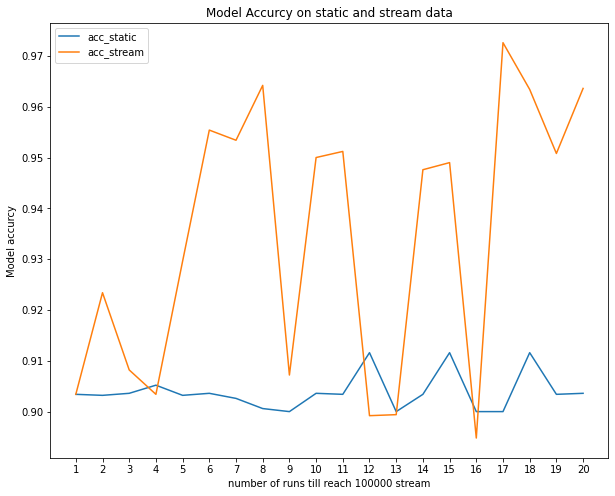

In [ ]:
#plot line graph to compare between accuracy of static and adaptive models
plot_performance_graph(run_times, acc_static_list, acc_stream_list, "acc_static", "acc_stream", "number of runs till reach 100000 stream", "Model accurcy", "Accurcy")

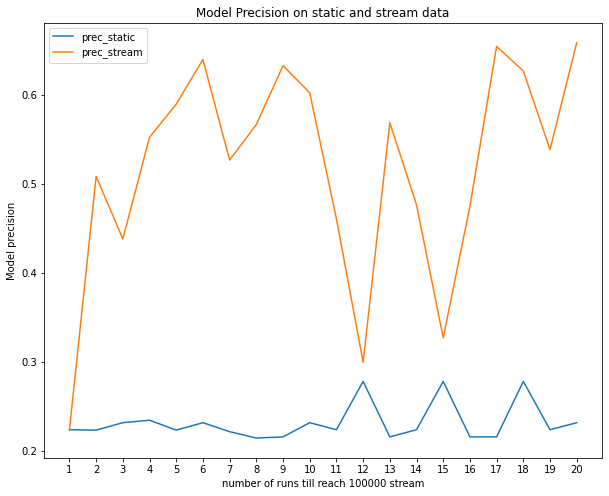

In [ ]:
#plot line graph to compare between precision of static and adaptive models
plot_performance_graph(run_times, prec_static_list, prec_stream_list, "prec_static", "prec_stream", "number of runs till reach 100000 stream", "Model precision", "Precision")

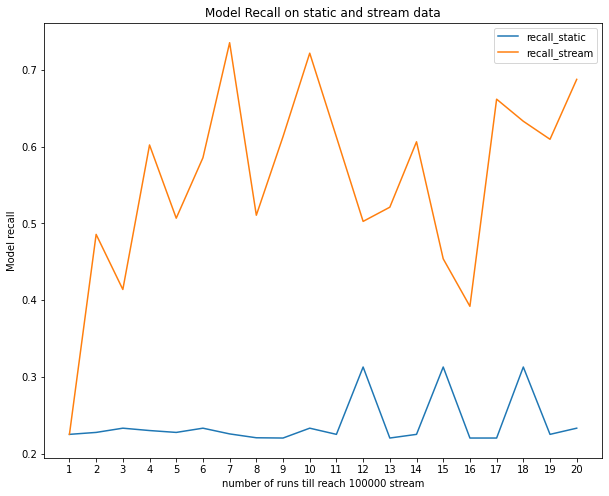

In [ ]:
#plot line graph to compare between recall of static and adaptive models
plot_performance_graph(run_times, recall_static_list, recall_stream_list, "recall_static", "recall_stream", "number of runs till reach 100000 stream", "Model recall", "Recall")

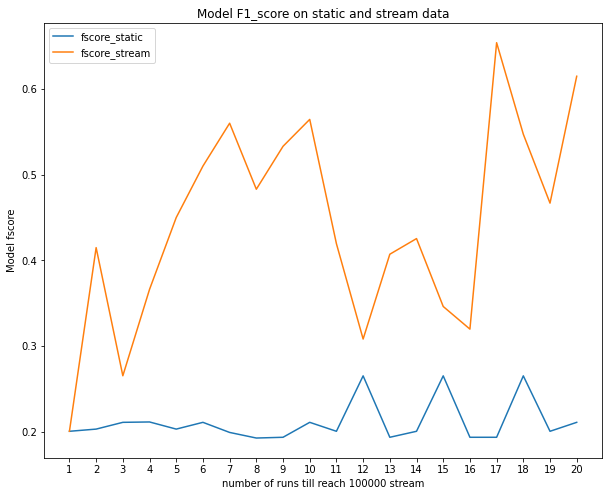

In [ ]:
#plot line graph to compare between f1_score of static and adaptive models
plot_performance_graph(run_times, fscore_static_list, fscore_stream_list, "fscore_static", "fscore_stream", "number of runs till reach 100000 stream", "Model fscore", "F1_score")

## References:
1. pandas, D. and Algiriyage, N., 2013. Delete the first three rows of a dataframe in pandas. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/16396903/delete-the-first-three-rows-of-a-dataframe-in-pandas>
2. w3resource. 2020. Matplotlib Basic: Plot two or more lines on same plot with suitable legends of each line - w3resource. [online] Available at: <https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php>
3. GeeksforGeeks. 2020. How to create an empty DataFrame and append rows & columns to it in Pandas? - GeeksforGeeks. [online] Available at: <https://www.geeksforgeeks.org/how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-pandas/>